In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns

# Version 3 (ODE)class SocialSpatialModel

In [3]:
class SocialSpatialModel:
    def __init__(self, grid_size, subpopulations, n_infected, contact_rates, exposure_rate, recovery_rate, epsilon, baseline_activity_rate, income_values):
            self.m = grid_size
            self.N_k = np.array(subpopulations)
            self.I_0 = np.array(n_infected)
            self.A = np.array(contact_rates)  # This will be adjusted based on activity rates
            self.alpha = exposure_rate
            self.gamma = recovery_rate
            self.epsilon = epsilon
            self.baseline_activity_rate = baseline_activity_rate
            self.income_values = income_values
            self.Q = self.compute_vulnerability(income_values)  # update use logistic model
            self.A = self.compute_activity_rate()  # 3.7: update activity rate using the compute activity rate method. 
            self.B = self.compute_beta()
            


    def compute_beta(self):
        m2 = self.m**2
        B = np.zeros((m2, m2)) # initialize beta with zeros

        denominator = np.sum(self.A * self.N_k) # denominator of the beta formula
        indices_2d = [(i // self.m, i % self.m) for i in range(m2)] # change to 2d grid index, for checking neighbor

        # case 1: i and j are neighbors (up, down, left, right)
        for i in range(m2):
            for j in range(m2):
                if i != j:
                    diff = (abs(indices_2d[i][0] - indices_2d[j][0]), abs(indices_2d[i][1] - indices_2d[j][1]))
                    if diff in [(1, 0), (0, 1)]:  # check for up, down, left, right
                        B[i, j] = (1 - self.epsilon) * self.Q[i] * self.A[i] * self.A[j] / denominator
        # case 2: i = j, self transmission rate
        for i in range(m2):
            B[i, i] = (1 - self.epsilon) * self.Q[i] * self.A[i]**2 / denominator + self.epsilon * self.Q[i] * self.A[i] / self.N_k[i]

        return B
    
    def compute_vulnerability(self, income_levels):
        # vulnerability based on income levels
        logit_q = np.zeros_like(income_levels, dtype=float)
        for i, income in enumerate(income_levels):
            Z1 = 1 if 0.25 < income <= 0.50 else 0  # T1
            Z2 = 1 if income > 0.50 else 0  # T2
            logit_q[i] = -2 + Z1 + 2 * Z2
        
        # turn logit to probability
        q = 1 / (1 + np.exp(-logit_q))
        return q
    
    def compute_activity_rate(self):
        mul = np.random.uniform(0.8, 2, size = self.N_k.shape)
        baseline_activity_rate = 12
        adjusted_activity_rate = baseline_activity_rate * mul
        return adjusted_activity_rate
    
    def get_initial_state(self):
        # need to return X where X = (S, E, I, R)
        S0 = self.N_k - self.I_0
        E0 = np.zeros_like(self.N_k)
        I0 = self.I_0
        R0 = np.zeros_like(self.N_k)
        return np.concatenate([S0, E0, I0, R0])  # N^2 * 4 # a vector

    def derivative(self, X, t):
        m2 = self.m**2
        S, E, I, R = X[:m2], X[m2:2*m2], X[2*m2:3*m2], X[3*m2:]

        dsdt = -self.B @ I * S
        dedt = self.B @ I * S - self.alpha * E
        didt = self.alpha * E - self.gamma * I
        drdt = self.gamma * I
        return np.concatenate([dsdt, dedt, didt, drdt])  # this should be a vector of length N^2 * 4

In [4]:
income_values = np.array([0.2, 0.4, 0.6, 
                          0.3, 0.7, 0.1, 
                          0.5, 0.2, 0.4])

grid_size = 3
pop_grid = np.array([[2000, 1000, 2000], 
                     [1800, 2600, 1800], 
                     [2000, 1000, 2000]])

initial_infected = (1, 1)  # central cell

pop = pop_grid.flatten()  # flatten pop array to 1d
n_infected = np.zeros_like(pop)
n_infected[grid_size * initial_infected[0] + initial_infected[1]] = 1  # mark the initial infected cell

contact_rates = np.full(pop.shape, 1.0)
epsilon = 0.5
exposure_rate = 0.3 
recovery_rate = 0.1  

model = SocialSpatialModel(grid_size=grid_size, 
                           subpopulations=pop - n_infected, 
                           n_infected=n_infected, 
                           contact_rates=contact_rates, 
                           exposure_rate=exposure_rate, 
                           recovery_rate=recovery_rate, 
                           epsilon=epsilon, 
                           baseline_activity_rate=12,  # assuming a base rate
                           income_values=income_values)


initial_state = model.get_initial_state()
beta_matrix = model.compute_beta()

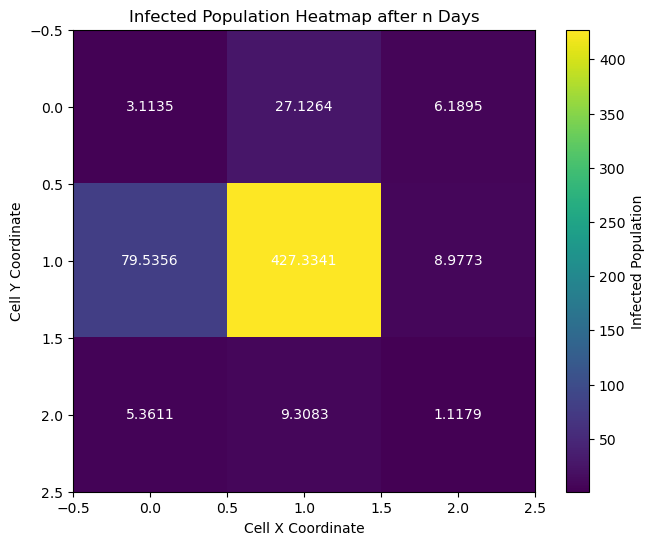

In [5]:
days = 10  # number of days
dt = 1.0   # time step

t = np.arange(0, days, dt)
X = model.get_initial_state().astype(np.float64)

for _ in t:
    dXdt = model.derivative(X, _)  # calculate the derivatives
    X += dXdt * dt  # update the state

# reshape to extract the infected pop for the heatmap
num = model.m ** 2
S, E, I, R = X[:num], X[num:2*num], X[2*num:3*num], X[3*num:]
infected_pop = I.reshape(model.m, model.m)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(infected_pop, cmap='viridis', interpolation='nearest')

for i in range(infected_pop.shape[0]):
    for j in range(infected_pop.shape[1]):
        text = ax.text(j, i, f'{infected_pop[i, j]:.4f}', ha="center", va="center", color="w")

plt.colorbar(cax, label='Infected Population')
plt.title('Infected Population Heatmap after n Days')
plt.xlabel('Cell X Coordinate')
plt.ylabel('Cell Y Coordinate')
plt.show()

# Version 2 (spatial + SEIR)

In [16]:
class COVID19GeoSpatialModel:
    def __init__(self, initial_infected):
        self.grid_size = 3
        self.populations = np.array([[1000, 1200, 1400], 
                                     [1600, 1800, 2000], 
                                     [2200, 2400, 2600]])
        
        # SEIR initialization
        self.S = np.array(self.populations, dtype=np.float64)
        self.E = np.zeros_like(self.populations, dtype=np.float64)
        self.I = np.zeros_like(self.populations, dtype=np.float64)
        self.R = np.zeros_like(self.populations, dtype=np.float64)

        self.I[initial_infected] = 1  
        self.S[initial_infected] -= 1  
        self.activity_rates = np.full((self.grid_size, self.grid_size), 1.0)  # all activity rates set to 1
        self.epsilon = 0.5
        self.q_base = 0.3
        self.q_i = np.full((self.grid_size, self.grid_size), self.q_base)
        self.alpha = 0.2  # Rate of exposed individuals becoming infectious
        self.gamma = 0.1  # Recovery rate of infectious individuals

    def calculate_activity_weighted_sum(self):
        return np.sum(self.activity_rates * self.populations)
    
    def calculate_transmission_rate(self, i, j):
        # returns the transmission rate from I to J
        if i != j:
            beta_ij = (1 - self.epsilon) * self.q_i[j[0], j[1]] * (self.activity_rates[i[0], i[1]] * self.I[i[0], i[1]]) / self.populations[j[0], j[1]]
        else:
            beta_ij = (self.epsilon * self.q_i[i[0], i[1]] * self.I[i[0], i[1]]) / self.populations[i[0], i[1]]
        return beta_ij
    
    def update_SEIR_states(self):
        new_exposures = np.zeros_like(self.S)
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]  # Up, down, left, right neighbors
                new_exposures[i, j] = 0
                for nb in neighbors:
                    if 0 <= nb[0] < self.grid_size and 0 <= nb[1] < self.grid_size:
                        intracell_beta = self.calculate_transmission_rate((i, j), nb) 
                        # QUESTION: How to calculate the new exposed (or should it be infecteds?) from the beta_i<j?
                intercell_beta = self.calculate_transmission_rate((i, j), (i, j))
                
        
        # Update S, E, I, R
        newE_to_I = self.alpha * self.E
        newI_to_R = self.gamma * self.I
        
        self.S = self.S.astype(float) - new_exposures
        self.E = self.E.astype(float) + new_exposures.astype(float) - newE_to_I
        self.I = self.I.astype(float) + newE_to_I - newI_to_R
        self.R = self.R.astype(float) + newI_to_R
    
    def run_simulation(self, time_steps):
        for _ in range(time_steps):
            self.update_SEIR_states()
        
        # Display final states after simulation
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
        compartments = [(self.S, 'Susceptible'), (self.E, 'Exposed'), (self.I, 'Infected'), (self.R, 'Recovered')]
        
        for ax, (compartment, title) in zip(axes.flatten(), compartments):
            sns.heatmap(compartment, ax=ax, annot=True, fmt=".1f", cmap="viridis")
            ax.set_title(title)
        
        plt.tight_layout()
        plt.show()

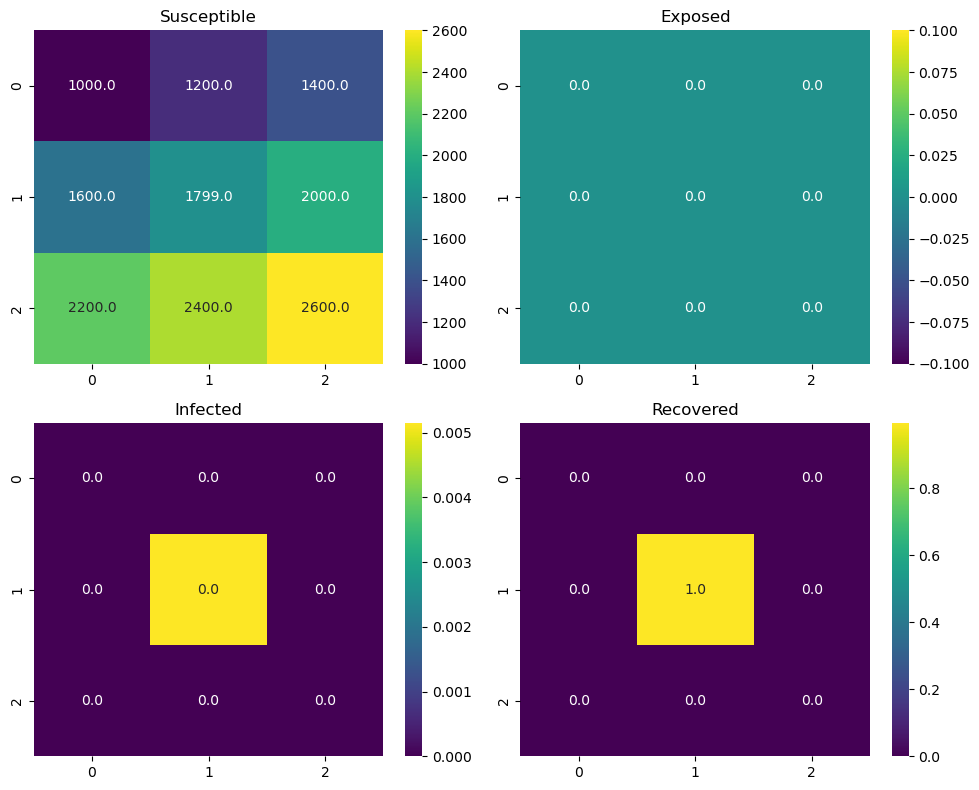

In [17]:
# Initialize the model with one infected individual in the center cell (1, 1)
initial_infected = (1, 1)
model = COVID19GeoSpatialModel(initial_infected)

# Run the simulation
time_steps = 50
model.run_simulation(time_steps)

# Version 1 (only spatial)

In [5]:
class COVID19GeoSpatialModel:
    def __init__(self):
        """
        TODO: Initialize model parameters
        self.populations: population in each grid
        self.high_income_proportion: proportion of high income population
        self.activity_rates: activity rates for each cell (mobility)
        self.epsilon: intercell vs. intracell transmission trade-off
        self.race_distribution
        self.ses_distribution: social economic distribution
        self.q_base: base transmission probability
        self.activity_weighted_sum:
        self.q_i: contact in D_i becomes a tranmission
        """
        self.populations, self.high_income_proportion = self.initialize_grid_parameters()
        
        self.activity_rates = [2 for _ in range(9)]
        self.epsilon = 0.5
        
        self.race_distribution, self.ses_distribution = self.initialize_race_ses_parameters()
        
        self.q_base = 0.5  
        self.activity_weighted_sum = self.calculate_activity_weighted_sum()
        self.q_i = self.estimate_transmission_probability()

    def initialize_grid_parameters(self):
        populations = [1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600] # random choose values, will be adjusted based on Michigan county data
        high_income_proportion = 0.4 # random choose value
        return populations, high_income_proportion

    def initialize_race_ses_parameters(self):
        # define race and SES distributions for each cell
        # upon to adjust based on ACS or US Census information
        # now we assume equal distribution among 3 races and 3 SES
        race_dist = np.full((9, 3), 1/3)  
        ses_dist = np.full((9, 3), 1/3) 
        return race_dist, ses_dist

    def calculate_activity_weighted_sum(self):
        return sum(a * N for a, N in zip(self.activity_rates, self.populations))

    def estimate_transmission_probability(self):
        # should be adjusted to a logistic regression for q_i
        # based on race and SES
        # assume for simplicity for now
        q_i = [self.q_base for _ in range(9)]  
        return q_i

    def calculate_transmission_rate(self, i, j):
        # maybe make this part more structured and easy to understand. 
        if i != j:
            beta = (1 - self.epsilon) * self.q_i[i] * (self.activity_rates[i] * self.activity_rates[j]) / self.activity_weighted_sum
        else:
            beta = ((1 - self.epsilon) * self.q_i[i] * (self.activity_rates[i] ** 2) / self.activity_weighted_sum) + \
                   (self.epsilon * self.q_i[i] * self.activity_rates[i] / self.populations[i])
        return beta

    def run_simulation(self):
        beta_example = self.calculate_transmission_rate(0, 1)
        print(f"Example Transmission Rate (D_1 to D_2): {beta_example}")
        self.grid_plot()

    def grid_plot(self):
        beta_matrix = np.zeros((3, 3))
        for i in range(3):
            for j in range(3):
                beta_matrix[i, j] = self.calculate_transmission_rate(i * 3 + j, i * 3 + j)
        sns.heatmap(beta_matrix, annot=True, fmt=".6f", cmap="viridis")
        plt.title("Intracell Transmission Rates")
        plt.show()

Example Transmission Rate (D_1 to D_2): 3.08641975308642e-05


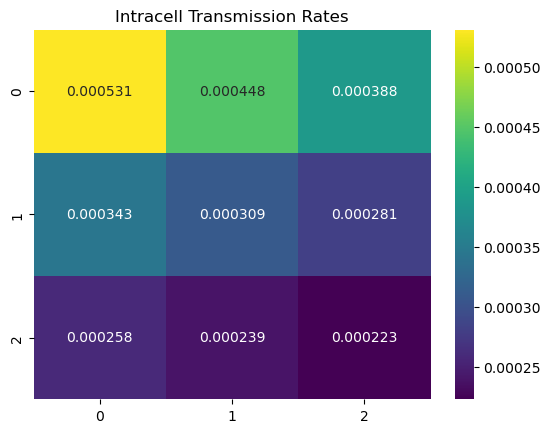

In [6]:
model = COVID19GeoSpatialModel()
model.run_simulation() # not sure why only first row displayed